In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
pd.set_option('mode.chained_assignment', None)

## Carga de datos en bruto

In [77]:
df = pd.read_csv("data/data.csv")

In [80]:
# ejemplo de datos para probar le front
df_sample = df.sample(n=50)
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample.drop(columns=["accion", "accion_modelo"])
df_sample.to_csv("data/data_sample_front.csv")

In [3]:
df.head()

,numero_aviso,marca,codigo_irs,nombre,accion,accion_modelo,marca.1,anio,linea,grupo,subgrupo,tipo_carroceria
0,44023,HYUNDAI,03060003nndn,computadora,cambiar,cambiar,HYUNDAI,2012,accent,3,6,sedan
1,44023,HYUNDAI,03030005nndn,cable ground de bateria,cambiar,cambiar,HYUNDAI,2012,accent,3,3,sedan
2,17203,NISSAN,02090225nidn,pollera delantero izquierdo,cambiar,cambiar,NISSAN,2015,FRONTIER,2,9,pickup
3,37133,KIA,03040016nidn,lampara delantero izquierdo,cambiar,reparar,KIA,2018,rio,3,4,sedan
4,17434,HONDA,02090021nddn,bisagra derecho tapa motor,cambiar,cambiar,HONDA,2016,CRV,2,9,camioneta


In [4]:
print(f"Cantidad de variables {len(df.columns)}, cantidad de observaciones {len(df)}")

Cantidad de variables 12, cantidad de observaciones 103032


In [5]:
profile = ProfileReport(df, minimal=False)
profile.to_file("eda_files/output_initial.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Procesado de datos según recomendaciones EDA inicial

En esta etapa se analizaran las variables en función de las recomendaciones del EDA, esto con el fin de tener los datos refinados para modelaros posteriormente, **el análisis preliminar se encuentra** como un pagina web en la la ubicación: **eda_files/output_initial.htm**, este archivo tiene de manera grafica la siguiente información:

* Descripción general de las variables
* Descripción detallada de las variables
* Matriz de interacciones
* Matriz de correlación (**punto solicitado en el documento del análisis**)
* Recomendaciones del estado de las variables
* Información estadística de cada variable

### Filas repetidas (Descartado)

**Nota:** Se descarta esta acción dado que al no tener un identificador de fecha podría ser un vehículo igual con un cambio de partes similar, pero se deja el código en caso de enriquecer la información en un futuro

*Para este caso se tiene 122 filas duplicadas que corresponden al 0.1% del total de los datos aunque no es significativo el borrarlas no lleva un mayor esfuerzo y se proceden a eliminar*

In [6]:
len(df)

103032

In [7]:
len(df)

103032

### Variable numero_aviso

**Numero de aviso:** es un idenficador único que agrupa un siniestro, bajo este ID se puede agrupar las distintas piezas de un siniestro.

**Nota:** Esta variable se esta tomando como tipo numero cuando en realidad es una categoría por esta razón se procede a transformar para poder utilizar de manera mas eficiente en las agrupaciones y en los modelos si se ve su utilidad tratarla como tal

In [8]:
df["numero_aviso"].describe()

count    103032.000000
mean      44333.365479
std       16371.133507
min        8437.000000
25%       29917.000000
50%       47329.000000
75%       58702.000000
max       67229.000000
Name: numero_aviso, dtype: float64

In [9]:
df["numero_aviso"] = df["numero_aviso"].astype(str)

In [10]:
df["numero_aviso"].describe()

count     103032
unique      8708
top        50067
freq         111
Name: numero_aviso, dtype: object

Se puede observar que se están analizando 8708 eventos

### Variable Código irs

**Código irs:** Es un identificador único de cada pieza. Puede que una pieza tenga diferentes nombres (bómper delantero o defensa delantero, bómper del., etc.), pero el código irs será único.

In [11]:
df_irs = df.groupby(["codigo_irs", "nombre"], as_index=False).count()

In [12]:
df_irs = df_irs[["codigo_irs", "numero_aviso", "nombre"]]
df_irs = df_irs.rename(columns={"numero_aviso": "count"})
df_irs = df_irs.sort_values("count", ascending=False)
df_irs = df_irs[0:12].reset_index(drop=True)

In [13]:
df_irs

,codigo_irs,count,nombre
0,02090112nndn,3134,defensa delantero
1,02090113nntn,2194,defensa trasero
2,02090066nddn,2145,guardafango derecho
3,02090200nndn,2111,tapa motor
4,02090067nidn,2077,guardafango izquierdo
5,02090129nndn,1449,parrilla
6,02090143nddn,1416,puerta delantero derecho
7,03040015nddn,1399,lampara delantero derecho
8,03040016nidn,1369,lampara delantero izquierdo
9,02090144nidn,1347,puerta delantero izquierdo


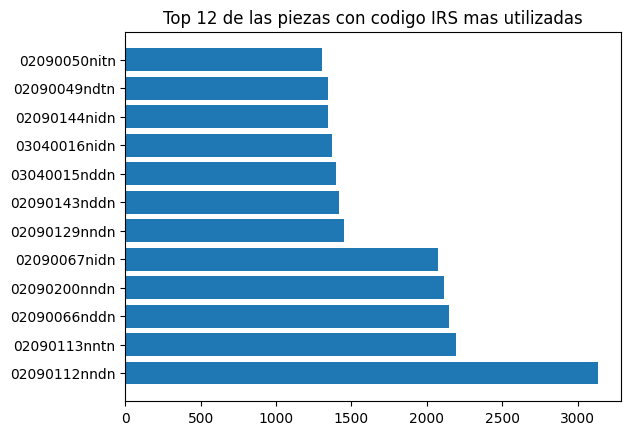

In [14]:
plt.Figure(figsize=(8, 6))
plt.barh(df_irs["codigo_irs"], df_irs["count"])
plt.title("Top 12 de las piezas con codigo IRS mas utilizadas")
plt.show()

Esta variable no tiene problemas salvo una alta cardinalidad es decir muchas categorías, para este caso 1665 valores distintos, pero el top 12 de códigos mas presentes en la base de datos da una idea mas clara de la información

### Variable nombre

**nombre:** nombre de la pieza.

Esta variable no tiene mayor complicación salvo sus valores únicos ya que son 1741 vs 1665 del código irs es decir que pueden haber código irs repetidos con distinto nombre cosa que ya se mencionaba en el diccionario de variables

### Variable acción

**Acción:** Es la acción que finalmente se llevó a cabo sobre la pieza (target).

Esta variable siendo el objetivo del análisis no tiene valores NA y fácil determinar su frecuencia 

In [15]:
df["accion"].value_counts()

cambiar    75598
reparar    27434
Name: accion, dtype: int64

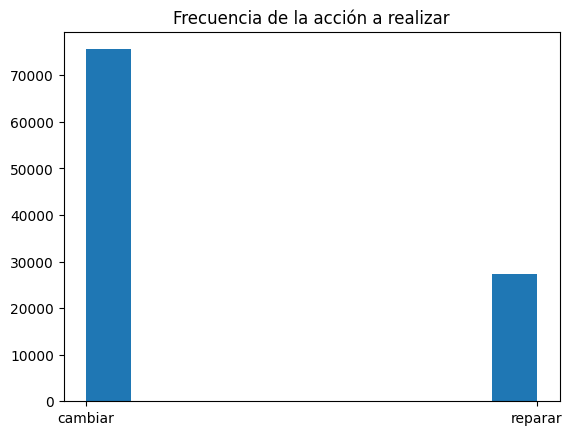

In [16]:
plt.Figure(figsize=(8, 6))
plt.hist(df["accion"])
plt.title("Frecuencia de la acción a realizar")
plt.show()

Se puede observar des balanceo en los datos caso que se debe tener en cuenta a la hora de plantear un modelo

### Acción módelo

**acción_modelo:** es la acción sugerida por el modelo actualmente desplegado
en producción.

Variable interesante para poder comparar

In [17]:
df["accion_modelo"].value_counts()

cambiar    67025
reparar    36007
Name: accion_modelo, dtype: int64

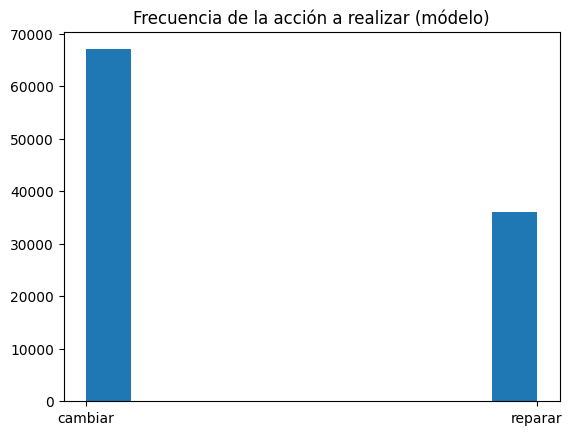

In [18]:
plt.Figure(figsize=(8, 6))
plt.hist(df["accion_modelo"])
plt.title("Frecuencia de la acción a realizar (módelo)")
plt.show()

In [19]:
# en esta parte se borran los duplicados dado que en el apartado del diagnostico del modelo actual se sugiere
df_accion = df.drop_duplicates() 
df_accion = pd.DataFrame(df["accion"].value_counts())
df_accion

,accion
cambiar,75598
reparar,27434


In [20]:
df_accion_modelo = pd.DataFrame(df["accion_modelo"].value_counts())
df_accion_modelo

,accion_modelo
cambiar,67025
reparar,36007


In [21]:
df_model_init = pd.concat([df_accion, df_accion_modelo], axis=1)
df_model_init

,accion,accion_modelo
cambiar,75598,67025
reparar,27434,36007


In [22]:
cambiar_dif =  (df_model_init["accion"][0] / df_model_init["accion_modelo"][0] - 1)
cambiar_dif 

0.12790749720253647

In [23]:
reparar_dif =  (1 - df_model_init["accion"][1] / df_model_init["accion_modelo"][1])
reparar_dif 

0.2380925931068959

Se puede observar como el modelo utilizado es menos efectivo en el caso de reparar piezas puede ser por el des balanceo de los datos, esta información es útil para el planteamiento del modelo

### Variable marca.1

**Marca:** marca del vehículo siniestrado i.e. Mazda, Chevrolet, Nissan.

Esta variable según el EDA no tien valores NA, no se realizará ningún tratamiento pero igual se calcula el top de marcas 

In [24]:
df["marca.1"].value_counts()[0:12]

HYUNDAI       22454
TOYOTA        19608
KIA           17090
NISSAN        13499
SUZUKI         7722
HONDA          5287
MITSUBISHI     3336
CHEVROLET      2555
MAZDA          2484
FORD           1935
ISUZU          1626
BMW             815
Name: marca.1, dtype: int64

### Variable anio

**Anio:** año de fabricación del vehículo.

**Nota:** Esta variable se esta tomando como tipo numero cuando en realidad es una categoría por esta razón se procede a transformar para poder utilizar de manera mas eficiente en las agrupaciones y en los modelos si se ve su utilidad tratarla como tal, se sugiere trabajarla por rangos para a la hora de transformar a variable dummy no tener tantas columnas

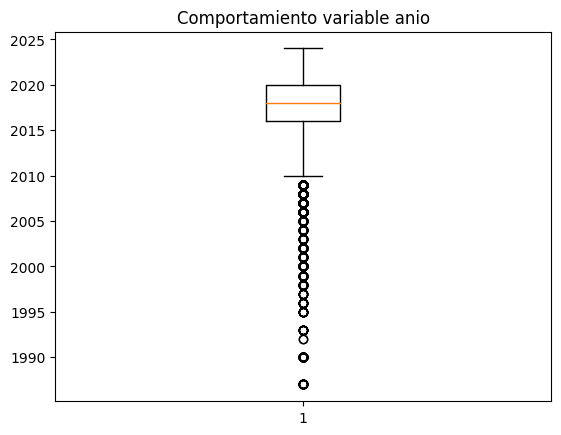

In [25]:
plt.Figure(figsize=(8, 6))
plt.boxplot(df["anio"])
plt.title("Comportamiento variable anio")
plt.show()

In [26]:
df["anio"].describe()

count    103032.000000
mean       2017.966311
std           3.421135
min        1987.000000
25%        2016.000000
50%        2018.000000
75%        2020.000000
max        2024.000000
Name: anio, dtype: float64

In [27]:
def anio_group(anio):

    if anio <= 2024 and anio >= 2021:
        anio_range = "2024 - 2021"
    elif anio <= 2020 and anio >= 2017:
        anio_range = "2020 - 2017"
    elif anio <= 2016 and anio >= 2013:
        anio_range = "2016 - 2013"
    elif anio <= 2012 and anio >= 2009:
        anio_range = "2012 - 2009"
    elif anio <= 2008 and anio >= 2005:
        anio_range = "2008 - 2005"
    else:
        anio_range = "2004 - atrás"
    
    return anio_range

In [28]:
anio_range_list = list(map(anio_group, list(df["anio"])))

In [29]:
df["anio_range"] = anio_range_list

In [30]:
df = df.drop(columns=["anio"])

Se crea la columna anio_range con los datos agrupados y se borra la variable anio

### Variable linea

**Línea:** Línea del vehículo i.e. Logan, Sail, Spark, Accent.

Esta es una variable categórica con 41 valores únicos puede ser importante para al análisis

In [31]:
df_linea = df.groupby(["linea"], as_index=False).count()

In [32]:
df_linea = df_linea[["linea", "numero_aviso"]]
df_linea = df_linea.rename(columns={"numero_aviso": "count"})
df_linea = df_linea.sort_values("count", ascending=False)
df_linea = df_linea[0:12].reset_index(drop=True)

In [33]:
df_linea

,linea,count
0,RIO,3810
1,HILUX,3790
2,ACCENT,3277
3,hilux,2537
4,VERSA,2516
5,rio,2489
6,YARIS,2084
7,accent,2049
8,TUCSON,1945
9,SPORTAGE,1710


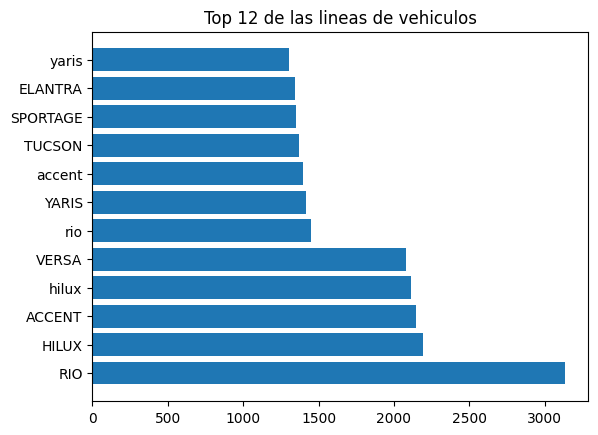

In [34]:
plt.Figure(figsize=(8, 6))
plt.barh(df_linea["linea"], df_irs["count"])
plt.title("Top 12 de las lineas de vehiculos")
plt.show()

### Grupo y subgrupo

**Grupo y subgrupo:** Id que arrojan información sobre el tipo de repuesto (Electricidad, mecánica, carrocería, suspensión, airbags, etc.). Estos id están codificados

Estas variables deben ser consideradas como categóricas

In [35]:
df["grupo"] = df["grupo"].astype(str)

In [36]:
df["subgrupo"] = df["subgrupo"].astype(str)

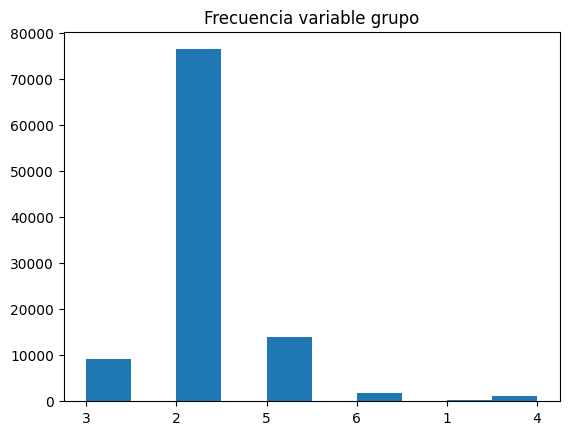

In [37]:
plt.Figure(figsize=(8, 6))
plt.hist(df["grupo"])
plt.title("Frecuencia variable grupo")
plt.show()

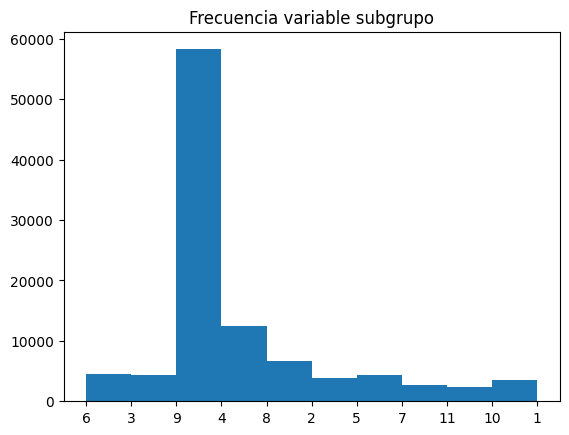

In [38]:
plt.Figure(figsize=(8, 6))
plt.hist(df["subgrupo"])
plt.title("Frecuencia variable subgrupo")
plt.show()

### Variable tipo_carroceria

**Tipo de carrocería:** tipo de cuerpo del vehículo i.e. camioneta, sedan, campero.

Esta variable es categórica no tiene mayores transformaciones

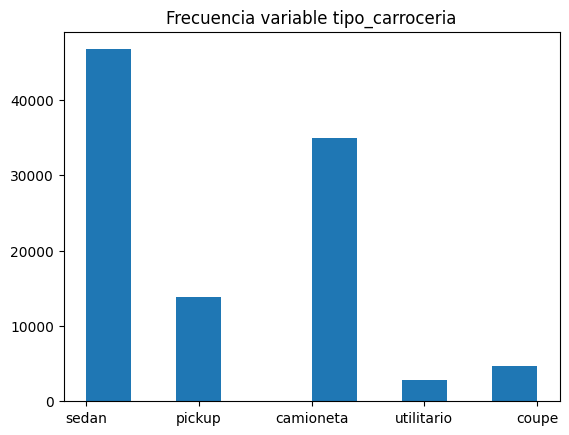

In [39]:
plt.Figure(figsize=(8, 6))
plt.hist(df["tipo_carroceria"])
plt.title("Frecuencia variable tipo_carroceria")
plt.show()

## Resultados segundo EDA

In [40]:
profile = ProfileReport(df, minimal=False)
profile.to_file("eda_files/output_clean.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/oscar/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/home/oscar/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

En esta etapa se analizaran las variables en función de las recomendaciones del EDA, esto con el fin de tener los datos refinados para modelaros posteriormente, **el análisis posterior a limpiar las variables se encuentra** como un pagina web en la la ubicación: **eda_files/output_clean.htm**, este archivo tiene de manera grafica la siguiente información:

* Descripción general de las variables
* Descripción detallada de las variables
* Matriz de interacciones
* Matriz de correlación (**punto solicitado en el documento del análisis**)
* Recomendaciones del estado de las variables
* Información estadística de cada variable

In [41]:
df.columns

Index(['numero_aviso', 'marca', 'codigo_irs', 'nombre', 'accion',
       'accion_modelo', 'marca.1', 'linea', 'grupo', 'subgrupo',
       'tipo_carroceria', 'anio_range'],
      dtype='object')

## Actividades requeridas para el análisis 

### 1. Realizar un diagnóstico del modelo y determinar su desempeño actual en una aseguradora.

En el análisis exploratorio se reviso esta parte pero aquí se entra mas en detalle del estado del modelo actual

In [42]:
df_error = df.groupby(by=["accion", "accion_modelo"], as_index=False).count()
df_error = df_error[["accion", "accion_modelo", "grupo"]]
df_error = df_error.rename(columns={"grupo": "count"})
df_error

,accion,accion_modelo,count
0,cambiar,cambiar,53908
1,cambiar,reparar,21690
2,reparar,cambiar,13117
3,reparar,reparar,14317


In [43]:
df_error["accion_resume"] = df_error["accion"] + "_" + df_error["accion_modelo"]

In [44]:
df_error.head()

,accion,accion_modelo,count,accion_resume
0,cambiar,cambiar,53908,cambiar_cambiar
1,cambiar,reparar,21690,cambiar_reparar
2,reparar,cambiar,13117,reparar_cambiar
3,reparar,reparar,14317,reparar_reparar


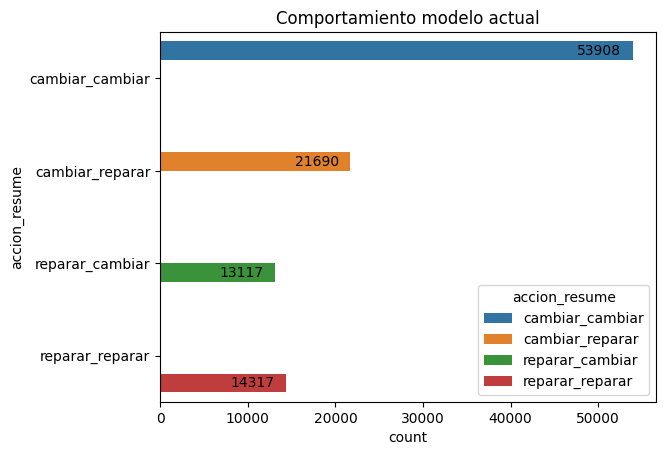

In [45]:
ax = sns.barplot(x='count', y='accion_resume',
                 hue='accion_resume', data=df_error,
                 errwidth=0)
 
for i in ax.containers:
    ax.bar_label(i, padding=-40)
ax.set_title('Comportamiento modelo actual')
plt.show()

In [46]:
# predicciones correctas cambiando partes
t_p = df_error["count"][df_error["accion_resume"] == "cambiar_cambiar"]
t_p[0]

53908

In [47]:
# predicciones correctas reparando partes
t_n = df_error["count"][df_error["accion_resume"] == "reparar_reparar"]
t_n[3]

14317

In [48]:
f_p = df_error["count"][df_error["accion_resume"] == "cambiar_reparar"]
f_p[1]

21690

In [49]:
f_n = df_error["count"][df_error["accion_resume"] == "reparar_cambiar"]
f_n[2]

13117

In [50]:
accuracy = (t_p[0] + t_n[3]) / len(df)
accuracy

0.6621729171519528

**Exactitud del módelo actual = 66.0%**

In [51]:
print(f"La exactitud del modelo es de {round(accuracy, 2) * 100}% con esto podemos establecer una línea base para los modelos que se van a proponer")

La exactitud del modelo es de 66.0% con esto podemos establecer una línea base para los modelos que se van a proponer


In [52]:
precision = t_p[0] / (t_p[0] + f_p[1])
precision

0.7130876478213709

In [74]:
recall = t_p[0] / (t_p[0] + f_n[2])
recall

0.8042969041402461

**Nota:** Analizando la *precision 71.3%* y el *recall 80.4%* del modelo actual se puede observar que el modelo actual tiene a tener mas falsos positivos, es decir se equivoca mas cuando la acción es cambiar cuando la refacción se puede reparar

In [64]:
df_model_acc = df[["accion", "accion_modelo", "nombre", "codigo_irs"]]
df_model_acc.head()

,accion,accion_modelo,nombre,codigo_irs
0,cambiar,cambiar,computadora,03060003nndn
1,cambiar,cambiar,cable ground de bateria,03030005nndn
2,cambiar,cambiar,pollera delantero izquierdo,02090225nidn
3,cambiar,reparar,lampara delantero izquierdo,03040016nidn
4,cambiar,cambiar,bisagra derecho tapa motor,02090021nddn


In [65]:
def bad_prediction(row_1, row_2):
    if row_1 == row_2:
        prediction = False
    else:
        prediction = True
    return prediction

In [66]:
bad_pred = list(map(bad_prediction, list(df["accion"]), list(df["accion_modelo"])))

In [67]:
df_model_acc["bad_pred"] = deepcopy(bad_pred)

In [68]:
df_model_acc.head()

,accion,accion_modelo,nombre,codigo_irs,bad_pred
0,cambiar,cambiar,computadora,03060003nndn,False
1,cambiar,cambiar,cable ground de bateria,03030005nndn,False
2,cambiar,cambiar,pollera delantero izquierdo,02090225nidn,False
3,cambiar,reparar,lampara delantero izquierdo,03040016nidn,True
4,cambiar,cambiar,bisagra derecho tapa motor,02090021nddn,False


In [69]:
df_bad_pred = pd.get_dummies(df_model_acc["bad_pred"], prefix="bad_pred")
df_bad_pred

,bad_pred_False,bad_pred_True
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
103027,1,0
103028,1,0
103029,0,1
103030,1,0


In [70]:
df_model_acc_top10 = pd.concat([df_model_acc, df_bad_pred], axis=1)
df_model_acc_top10.tail()

,accion,accion_modelo,nombre,codigo_irs,bad_pred,bad_pred_False,bad_pred_True
103027,cambiar,cambiar,deflector plastico marco frontal,05050023nndn,False,1,0
103028,cambiar,cambiar,cubre polvo plastico trasero izquierdo,02090076nitn,False,1,0
103029,cambiar,reparar,pollera trasero izquierdo,02090227nitn,True,0,1
103030,cambiar,cambiar,eje de mando,05070010nnni,False,1,0
103031,reparar,reparar,punta chasis trasero izquierdo,02090150nitn,False,1,0


In [71]:
df_model_acc_top10 = df_model_acc_top10.groupby(by=["codigo_irs", "nombre"],
                                                as_index=False).agg({"bad_pred_False": "sum",
                                                                     "bad_pred_True": "sum",
                                                                     "bad_pred": "count"})
df_model_acc_top10 = df_model_acc_top10.rename(columns={"bad_pred": "count"})
df_model_acc_top10 = df_model_acc_top10.sort_values('bad_pred_True', ascending=False)
df_model_acc_top10 = df_model_acc_top10.reset_index(drop=True)

In [72]:
df_model_acc_top10["error"] = round(df_model_acc_top10["bad_pred_True"] / df_model_acc_top10["count"], 2) * 100

### Top de 10 repuestos con pero desempeño del modelo

In [75]:
df_model_acc_top10.head(10)

,codigo_irs,nombre,bad_pred_False,bad_pred_True,count,error
0,02090112nndn,defensa delantero,1856,1278,3134,41.0
1,02090066nddn,guardafango derecho,1139,1006,2145,47.0
2,02090067nidn,guardafango izquierdo,1087,990,2077,48.0
3,02090200nndn,tapa motor,1155,956,2111,45.0
4,02090113nntn,defensa trasero,1248,946,2194,43.0
5,02090143nddn,puerta delantero derecho,764,652,1416,46.0
6,02090144nidn,puerta delantero izquierdo,731,616,1347,46.0
7,02090107nndn,marco radiadores,579,549,1128,49.0
8,02090049ndtn,guardafango trasero derecho,808,536,1344,40.0
9,02090050nitn,guardafango trasero izquierdo,787,518,1305,40.0


**Nota:** el término **bad_pred_True** indica que la predicción fue erróneav es decir mala predicción es Verdadera

In [76]:
df.to_csv("data/data_clean.csv")